In [1]:
# Store TODAY articles in SQL database

In [42]:
# Import packages
import sqlite3
import pandas as pd
import os
import re
from textacy.preprocessing.resources import RE_URL
import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
from collections import Counter
def count_words(df, column = 'tokens', preprocess = None, min_freq = 2):
    # Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    # Create counter and run through all the data
    counter = Counter()
    df[column].map(str).map(update)
    
    # Transform counter into a Dataframe
    freq_df = pd.DataFrame.from_dict(counter, orient = 'index', columns = ['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending = False)

In [4]:
# Import data

# Extract relevant files
onlyfiles = [f for f in os.listdir() if "today_news_scraper_article_v3_" in f and ".csv" in f]

# Bind the relevant files
df = pd.DataFrame()
for item in onlyfiles:
    try:
        df_item = pd.read_csv(item)
    except:
        pass
    df = pd.concat([df, df_item], axis = 0)
    df = df.drop_duplicates(subset = ['Link'], keep = 'first').reset_index(drop = True)
    #print("Filename {} successfully imported and appended to df".format(item))
    

In [5]:
# Setting up database
db_name = "today_news.db"
con = sqlite3.connect(db_name)

# Insert df to database table
df.to_sql("articles", con, index = False, if_exists = "replace") # Save df to database table articles and overwrite any existing data

# Close connection
con.close()

In [6]:
# Extract data from database table articles
con = sqlite3.connect(db_name)
df2 = pd.read_sql("select * from articles", con)
con.close()

In [7]:
print(f"Number of rows: {df2.shape[0]}\nNumber of columns: {df2.shape[1]}")
print(df[['Date','Article']].head())

Number of rows: 1334
Number of columns: 9
         Date                                            Article
0  2020-12-26  SINGAPORE — Singapore reported 10 new cases of...
1  2020-12-26  SINGAPORE — A new year is in sight but old pra...
2  2020-12-26  SINGAPORE — The Ministry of Health (MOH) said ...
3  2020-12-26  SINGAPORE — In 2012, one year after Workers' P...
4  2020-12-26  SINGAPORE — From Jan 1, a total of 18 more mos...


In [8]:
# Data preprocessing pipeline
# (Data Cleaning) SOURCE TEXT -> Identify noise -> Noise removal -> Character normalisation -> Data masking ->
# (Linguistic processing) CLEAN TEXT -> Tokenisation -> POS tagging -> Lemmatisation -> Named-entity recognition ->
# PREPARED TEXT

In [9]:
# Identify noise
import re
def noise_score(text, noise_pattern = re.compile(r'[&#<>{}\[\]\\]'), min_char = 20):
    if text == None or len(text) < min_char:
        return 0
    else:
        output = len(noise_pattern.findall(text))/len(text)
        return output
    
# Add new column to dataframe    
df2['Noise_Score'] = df2['Article'].apply(lambda x: noise_score(x))

# Get top 10 noisy records
df2[['Article','Noise_Score']].sort_values(by = 'Noise_Score', ascending = False).head(10)

Article  Noise_Score
1260  WASHINGTON — US President Joe Biden said Tuesd...     0.003378
798   SINGAPORE — Three food and beverage (F&B) outl...     0.002291
646   NEW YORK — Johnson & Johnson (J&J) on Friday (...     0.002271
1281  NEW YORK — US President Joe Biden on Wednesday...     0.002209
460   SINGAPORE — Certificate of Entitlement (COE) p...     0.002086
1012  SINGAPORE — Certificate of Entitlement (COE) p...     0.002053
85    SINGAPORE — A karaoke outlet in Orchard Road h...     0.001769
1257  TAIPEI — The de facto US and Canadian embassie...     0.001568
78    SINGAPORE — Deputy Prime Minister and Finance ...     0.001544
524   SINGAPORE — Tired of working in an office, Ms ...     0.001470

In [10]:
# Remove noise
import html
def noise_remove(text, min_char = 20):
    if text == None or len(text) < min_char:
        return None
    else:
        # Convert html escapes like &amp to &
        text = html.unescape(text)
        # Remove trailing spaces
        text = text.strip()
        # COUNTRYNAME —
        pattern  = re.compile(r'^\w*/*\w*\s*—')
        text = pattern.sub(' ', text)
        # HTML tags
        pattern = re.compile(r'<\w\s*\w*>')
        text = pattern.sub(' ', text)
        # Replace & with and
        pattern = re.compile(r'\s*&\s*')
        text = pattern.sub(' and ', text)
        # Remove trailing spaces
        text = text.strip()
        return text

# Add new column to dataframe
df2['Noise_Remove'] = df2['Article'].apply(noise_remove)

# Get first 10 records
print("First 10 records with noise removed: \n{}".format(df2['Noise_Remove'].head(10)))

# Measure noise
df2['Noise_Remove_Noise_Score'] = df2['Noise_Remove'].apply(noise_score)

# Get top 10 noisy records
print("Top 10 noisy records: \n{}".format(df2[['Noise_Remove','Noise_Remove_Noise_Score']].sort_values(by = 'Noise_Remove_Noise_Score', ascending = False).head(10)))

First 10 records with noise removed: 
0    Singapore reported 10 new cases of Covid-19 on...
1    A new year is in sight but old practices must ...
2    The Ministry of Health (MOH) said on Saturday ...
3    In 2012, one year after Workers' Party (WP) me...
4    From Jan 1, a total of 18 more mosques will of...
5    South Korea posted its second-highest daily nu...
6    Scientists in Singapore are keen to debunk the...
7    One of the new cases of Covid-19 reported on F...
8    Groups of up to eight people will be allowed f...
9    A man who was charged last week with murdering...
Name: Noise_Remove, dtype: object
Top 10 noisy records: 
                                           Noise_Remove  \
1257  The de facto US and Canadian embassies in Taiw...   
78    Deputy Prime Minister and Finance Minister Hen...   
840   GrabPay, Singtel Dash and Liquid Pay users can...   
1216  Activists across Asia held rallies on Sunday (...   
1248  HONG KONG — Fans of several popular K-pop grou...   
8

In [11]:
# Character normalisation
import textacy.preprocessing as tprep

def normalise_text(text):
    if text == None:
        return None
    else:
        text = tprep.normalize_hyphenated_words(text) # Reassembles words that were separated by a line break
        text = tprep.normalize_quotation_marks(text) # Replaces fancy quotation marks with ASCII counterpart
        text = tprep.normalize_unicode(text) # Unifies different codes of accented characters in Unicode
        text = tprep.remove_accents(text) # Replaces accented characters with ASCII if possible, or drops them
        return text
# Add column to df2
df2['Normalise_Text'] = df2['Noise_Remove'].apply(normalise_text)

# Measure noise
df2['Normalise_Text_Noise_Score'] = df2['Normalise_Text'].apply(noise_score)

# Get first 10 records
print("First 10 records with noise removed: \n{}".format(df2['Normalise_Text'].head(10)))

# Get top 10 noisy records
print("Top 10 noisy records: \n{}".format(df2[['Normalise_Text','Normalise_Text_Noise_Score']].sort_values(by = 'Normalise_Text_Noise_Score', ascending = False).head(10)))


First 10 records with noise removed: 
0    Singapore reported 10 new cases of Covid-19 on...
1    A new year is in sight but old practices must ...
2    The Ministry of Health (MOH) said on Saturday ...
3    In 2012, one year after Workers' Party (WP) me...
4    From Jan 1, a total of 18 more mosques will of...
5    South Korea posted its second-highest daily nu...
6    Scientists in Singapore are keen to debunk the...
7    One of the new cases of Covid-19 reported on F...
8    Groups of up to eight people will be allowed f...
9    A man who was charged last week with murdering...
Name: Normalise_Text, dtype: object
Top 10 noisy records: 
                                         Normalise_Text  \
1257  The de facto US and Canadian embassies in Taiw...   
78    Deputy Prime Minister and Finance Minister Hen...   
840   GrabPay, Singtel Dash and Liquid Pay users can...   
1216  Activists across Asia held rallies on Sunday (...   
1248  HONG KONG — Fans of several popular K-pop grou...   

In [12]:
# Data masking
from textacy.preprocessing.resources import RE_URL
count_words(df = df2, column = 'Normalise_Text', preprocess = RE_URL.findall).head(3)

from textacy.preprocessing.replace import replace_urls
df2['Mask_Text'] = df2['Noise_Remove'].map(str).map(replace_urls)
df2['Mask_Normalise_Text'] = df2['Mask_Text'].map(str).map(normalise_text)
print(df2['Mask_Normalise_Text'])

0       Singapore reported 10 new cases of Covid-19 on...
1       A new year is in sight but old practices must ...
2       The Ministry of Health (MOH) said on Saturday ...
3       In 2012, one year after Workers' Party (WP) me...
4       From Jan 1, a total of 18 more mosques will of...
                              ...                        
1329    LOS ANGELES — Nine great apes at the San Diego...
1330    Police in northern India said on Thursday (Mar...
1331    Women in European Union countries have been di...
1332    China will resolutely deter any separatist act...
1333    NEW YORK — The next major flashpoint over Covi...
Name: Mask_Normalise_Text, Length: 1334, dtype: object


In [13]:
df2.rename(columns = {'Article': 'raw_text', 'Mask_Normalise_Text': 'text'}, inplace = True)

con = sqlite3.connect(db_name)
df2.to_sql("articles_cleaned", con, index = False, if_exists = "replace")
con.close()

In [14]:
# Tokenisation

In [15]:
# Linguistic processing with spaCy

In [16]:
# Tokenisation
# Linguistic processing with spaCy
# Import package
import spacy
# Load a small English language model and no need to disable parser and ner (named-entity recognition)
nlp = spacy.load('en_core_web_sm')
# If need to disable, run the following:
# nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner"])
# Check pipeline components
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x1c1b3db9a48>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x1c1b3c8c828>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x1c1b3c8c7c8>)]

In [17]:
# Processing text
# Display a table containing the tokens and their attributes from dataframe df2
def show_token_attributes(doc, include_punct = False):
    records = []
    for idx, key in enumerate(doc):
        if not key.is_punct or include_punct: # If token is not a punctuation
            record = {"token": idx,
                     "text": key.text,
                     "lemma_": key.lemma_,
                     "is_stop": key.is_stop,
                     "is_alpha": key.is_alpha,
                     "pos_": key.pos_,
                     "dep_": key.dep_,
                     "ent_type_": key.ent_type_,
                     "ent_iob_": key.ent_iob_}
            records.append(record)
    records_df = pd.DataFrame(records).set_index("token")
    return records_df

In [18]:
# Convert text to document with nlp pipeline from spacy
# Store every one hundred records into one text string
if df2.shape[0] % 100 > 0:
    hundreds = int(df2.shape[0]/100) + 1
else:
    hundreds = int(df2.shape[0]/100)

# Initialise dataframe to store unique records of tokens
records_df = pd.DataFrame()

# Loop over vector of hundreds
for item in range(0, hundreds):
    # Get index of dataframe to start
    start_index = item * 100
    # Get index of dtaaframe to end
    end_index = start_index + 100 if start_index + 100 < df2.shape[0] else df2.shape[0] + 1
    # Subset dataframe
    df_item = df2.iloc[start_index:end_index]
    # Get text for nlp
    text = ' '.join(df_item['text'])
    # Convert text to nlp document
    doc = nlp(text)
    # Show token attributes from document doc as a table of tokens and their associated attributes
    records_df_item = show_token_attributes(doc)
    # Concatenate with main dataframe
    records_df = pd.concat([records_df, records_df_item], axis = 0).reset_index(drop = True)
    # Show progress
    print(f"Number of records processed: {(end_index-1)}")
    
# Remove duplicate records
records_df = records_df.drop_duplicates().reset_index(drop = True)

# Show dataframe
print(f"Number of rows: {records_df.shape[0]}\nNumber of columns: {records_df.shape[1]}")
print(f"First 10 records: {records_df.head(10)}")

# Export dataframe
records_df.to_csv(f"today_news_articles_blueprint_tokens_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}.csv", index = False)


Number of records processed: 99
Number of records processed: 199
Number of records processed: 299
Number of records processed: 399
Number of records processed: 499
Number of records processed: 599
Number of records processed: 699
Number of records processed: 799
Number of records processed: 899
Number of records processed: 999
Number of records processed: 1099
Number of records processed: 1199
Number of records processed: 1299
Number of records processed: 1334
Number of rows: 102813
Number of columns: 8
First 10 records:         text     lemma_  is_stop  is_alpha   pos_    dep_ ent_type_ ent_iob_
0  Singapore  Singapore    False      True  PROPN   nsubj       GPE        B
1   reported     report    False      True   VERB    ROOT                  O
2         10         10    False     False    NUM  nummod  CARDINAL        B
3        new        new    False      True    ADJ    amod                  O
4      cases       case    False      True   NOUN    dobj                  O
5         o

In [19]:
# Customised tokenisation
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

def custom_tokeniser(nlp):
    
    # Use default patterns except the patterns matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes if pattern not in ["-", "_", "#"]]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes if pattern not in ["_"]]
    infixes = [pattern for pattern in nlp.Defaults.infixes if not re.search(pattern, "xx-xx")]
    
    # Output
    return Tokenizer(vocab = nlp.vocab,
                    rules = nlp.Defaults.tokenizer_exceptions,
                    prefix_search = compile_prefix_regex(prefixes).search,
                    suffix_search = compile_suffix_regex(suffixes).search,
                    infix_finditer = compile_infix_regex(infixes).finditer,
                    token_match = nlp.Defaults.token_match)

In [20]:
# Load English language model
nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = custom_tokeniser(nlp)



In [21]:
# Convert text to document with nlp pipeline from spacy
# Store every one hundred records into one text string
if df2.shape[0] % 100 > 0:
    hundreds = int(df2.shape[0]/100) + 1
else:
    hundreds = int(df2.shape[0]/100)

# Initialise dataframe to store unique records of tokens
records_df = pd.DataFrame()

# Loop over vector of hundreds
for item in range(0, hundreds):
    # Get index of dataframe to start
    start_index = item * 100
    # Get index of dtaaframe to end
    end_index = start_index + 100 if start_index + 100 < df2.shape[0] else df2.shape[0] + 1
    # Subset dataframe
    df_item = df2.iloc[start_index:end_index]
    # Get text for nlp
    text = ' '.join(df_item['text'])
    # Convert text to nlp document
    doc = nlp(text)
    # Show token attributes from document doc as a table of tokens and their associated attributes
    records_df_item = show_token_attributes(doc)
    # Concatenate with main dataframe
    records_df = pd.concat([records_df, records_df_item], axis = 0).reset_index(drop = True)
    # Show progress
    print(f"Number of records processed: {(end_index-1)}")
    
# Remove duplicate records
records_df = records_df.drop_duplicates().reset_index(drop = True)

# Show dataframe
print(f"Number of rows: {records_df.shape[0]}\nNumber of columns: {records_df.shape[1]}")
print(f"First 10 records: {records_df.head(10)}")

# Export dataframe
records_df.to_csv(f"today_news_articles_blueprint_customised_tokens_{datetime.datetime.now().strftime('%Y%m%d%H%M%S')}.csv", index = False)


Number of records processed: 99
Number of records processed: 199
Number of records processed: 299
Number of records processed: 399
Number of records processed: 499
Number of records processed: 599
Number of records processed: 699
Number of records processed: 799
Number of records processed: 899
Number of records processed: 999
Number of records processed: 1099
Number of records processed: 1199
Number of records processed: 1299
Number of records processed: 1334
Number of rows: 104334
Number of columns: 8
First 10 records:         text     lemma_  is_stop  is_alpha   pos_    dep_ ent_type_ ent_iob_
0  Singapore  Singapore    False      True  PROPN   nsubj       GPE        B
1   reported     report    False      True   VERB    ROOT                  O
2         10         10    False     False    NUM  nummod  CARDINAL        B
3        new        new    False      True    ADJ    amod                  O
4      cases       case    False      True   NOUN    dobj                  O
5         o

In [32]:
# Convert text to document with nlp pipeline from spacy
# Store every one hundred records into one text string
def convert_to_doc(df):
    
    # Create copy of dataframe
    df2 = df.copy()
    
    # Split dataframe df into rows of 100 for memory-friendly conversion to doc 
    if df2.shape[0] % 100 > 0:
        hundreds = int(df2.shape[0]/100) + 1
    else:
        hundreds = int(df2.shape[0]/100)

    # Initialise list to store documents
    doc_list = []
        
    # Loop over vector of hundreds
    for item in range(0, hundreds):
        # Get index of dataframe to start
        start_index = item * 100
        # Get index of dtaaframe to end
        end_index = start_index + 100 if start_index + 100 < df2.shape[0] else df2.shape[0] + 1
        # Subset dataframe
        df_item = df2.iloc[start_index:end_index]
        # Get text for nlp
        text = ' '.join(df_item['text'])
        # Convert text to nlp document
        doc = nlp(text)
        # Append to doc list
        doc_list.append(doc)
        # Show progress
        print(f"Number of records processed: {(end_index-1)}")
    
    # Show dataframe
    print(f"Number of elements: {len(doc_list)}")
    print(f"First 10 elements: {doc_list[0:10]}")

    # Output
    return doc_list

In [33]:
doc_list = convert_to_doc(df2)

Number of records processed: 99
Number of records processed: 199
Number of records processed: 299
Number of records processed: 399
Number of records processed: 499
Number of records processed: 599
Number of records processed: 699
Number of records processed: 799
Number of records processed: 899
Number of records processed: 999
Number of records processed: 1099
Number of records processed: 1199
Number of records processed: 1299
Number of records processed: 1334
Number of elements: 14


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
# Working with Stop Words

def remove_stopwords(doc):
    
    # Convert text to nlp class
    doc = nlp(text)
    
    # Extract non-stop words from original nlp
    non_stop = [item for item in doc if not item.is_stop and not item.is_punct]
    
    # List of non-stop words from customised nlp
    nlp.vocab['down'].is_stop = False
    


In [23]:
item_list = []
for item in nlp.vocab:
    item_list.append(item.text)

In [24]:
len(item_list)


10256

In [25]:
# Extracting lemmas based on Part of Speech
text = df2.text.iloc[0]
doc = nlp(text)
print(*[t.lemma_ for t in doc], sep = "|")

Singapore|report|10|new|case|of|Covid-19|on|Saturday|(|Dec|26|)|,|all|of|which|be|import|.|all|10|case|have|be|place|on|stay-home|notice|or|isolate|upon|arrival|in|Singapore|,|say|the|Ministry|of|Health|(|MOH|)|in|a|press|release|.|the|total|number|of|covid-19|case|in|Singapore|now|stand|at|58,519|.|"|-PRON-|be|still|work|through|the|detail|of|the|case|,|and|further|update|will|be|share|via|the|MOH|press|release|that|will|be|issue|tonight|,|"|MOH|say|.|this|report|will|be|update|.


In [26]:
[t.pos_ for t in doc]

['PROPN',
 'VERB',
 'NUM',
 'ADJ',
 'NOUN',
 'ADP',
 'PROPN',
 'ADP',
 'PROPN',
 'PUNCT',
 'PROPN',
 'NUM',
 'PUNCT',
 'PUNCT',
 'DET',
 'ADP',
 'DET',
 'AUX',
 'VERB',
 'PUNCT',
 'DET',
 'NUM',
 'NOUN',
 'AUX',
 'AUX',
 'VERB',
 'ADP',
 'ADJ',
 'NOUN',
 'CCONJ',
 'VERB',
 'SCONJ',
 'NOUN',
 'ADP',
 'PROPN',
 'PUNCT',
 'VERB',
 'DET',
 'PROPN',
 'ADP',
 'PROPN',
 'PUNCT',
 'PROPN',
 'PUNCT',
 'ADP',
 'DET',
 'NOUN',
 'NOUN',
 'PUNCT',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'ADJ',
 'NOUN',
 'ADP',
 'PROPN',
 'ADV',
 'VERB',
 'ADP',
 'NUM',
 'PUNCT',
 'PUNCT',
 'PRON',
 'AUX',
 'ADV',
 'VERB',
 'ADP',
 'DET',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 'PUNCT',
 'CCONJ',
 'ADJ',
 'NOUN',
 'VERB',
 'AUX',
 'VERB',
 'ADP',
 'DET',
 'PROPN',
 'NOUN',
 'NOUN',
 'DET',
 'VERB',
 'AUX',
 'VERB',
 'NOUN',
 'PUNCT',
 'PUNCT',
 'PROPN',
 'VERB',
 'PUNCT',
 'DET',
 'NOUN',
 'VERB',
 'AUX',
 'VERB',
 'PUNCT']

In [27]:
# Extracting lemmas based on Part of Speech
# Extract content words
text = df2.text.iloc[0]
doc = nlp(text)
nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[Singapore, cases, Covid-19, Saturday, Dec, cases, notices, arrival, Singapore, Ministry, Health, MOH, press, release, number, cases, Singapore, details, cases, updates, MOH, press, release, tonight, MOH, report]


In [28]:
# Extract tokens fr adjectives and nouns
import textacy
tokens = textacy.extract.words(doc, 
                              filter_stops = True, # default True, no stopwords
                              filter_punct = True, # default True, no punctuation
                              filter_nums = True, # default False, no numbers
                              include_pos = ['ADJ', 'NOUN'], # default None = include all
                              exclude_pos = None, # default None = exclude none
                              min_freq = 1) # minimum frequency of words
print(*[t for t in tokens], sep = "|")

new|cases|cases|stay-home|notices|arrival|press|release|total|number|Covid-19|cases|details|cases|updates|press|release|tonight|report


In [29]:
# Extracting lemmas based on Part of Speech
# Create function wrapping arounf textacy.extract.words with **kwargs ie keyword arguments
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

In [30]:
lemmas = extract_lemmas(doc, include_pos = ['ADJ', 'NOUN'])
print(*lemmas, sep = "|")

new|case|case|stay-home|notice|arrival|press|release|total|number|covid-19|case|detail|case|update|press|release|tonight|report


In [36]:
# Extract lemmas based on Part of Speech
def extract_lemmas_list(doc_list, **kwargs):
    # Initialise list to store lemmas from each document
    lemmas_list = []
    # Initialise num to show progress
    num = 0
    # Loop through list
    for item in doc_list:
        # Extract lemmas
        lemmas_item = [item2.lemma_ for item2 in textacy.extract.words(item, **kwargs)]
        # Append lemmas to list
        lemmas_list.append(lemmas_item)
        # Show progress
        num += 1
        print(f"Lemmas extracted for {num} document(s).")
    # Output
    return lemmas_list

In [37]:
# Extract lemmas based on Part of Speech
lemmas_list = extract_lemmas_list(doc_list, include_pos = ['ADJ', 'NOUN'])

Lemmas extracted for 1 document(s).
Lemmas extracted for 2 document(s).
Lemmas extracted for 3 document(s).
Lemmas extracted for 4 document(s).
Lemmas extracted for 5 document(s).
Lemmas extracted for 6 document(s).
Lemmas extracted for 7 document(s).
Lemmas extracted for 8 document(s).
Lemmas extracted for 9 document(s).
Lemmas extracted for 10 document(s).
Lemmas extracted for 11 document(s).
Lemmas extracted for 12 document(s).
Lemmas extracted for 13 document(s).
Lemmas extracted for 14 document(s).


In [45]:
# Plot Wordcloud
def plot_lemmas_wordcloud(lemmas_list):
    # Plot wordcloud
    # Combine elements of list into one list
    # Initialise empty list to store lemmas
    lemmas_wordcloud = []
    num = 0
    # Loop through list
    for item in lemmas_list:
        for item2 in item:
            # Append to list
            lemmas_wordcloud.append(item2)
        # Show progress
        num += 1
        print(f"{num} of {len(lemmas_list)} elements processed.")
    # Plot wordcloud
    # Set tile
    title = '{} Lemmas from TODAY News Articles'.format(len(lemmas_wordcloud))
    # Set figure size
    plt.figure(figsize = (60,40))
    # Create wordcloud object
    wc = WordCloud(max_words = 6000, width = 1800, height = 1000, colormap = 'Set3').generate(' '.join(lemmas_wordcloud))
    # Remove axes
    plt.axis('off')
    plt.title(title, size = 55)
    plt.imshow(wc, interpolation = 'bilinear')
    # Export plot as PNG
    plt.savefig('today_wordcloud_news_articles_blueprint_' + datetime.datetime.now().strftime('%Y%m%d%H%M%S') + '.png')
    # Output
    return lemmas_wordcloud

1 of 14 elements processed.
2 of 14 elements processed.
3 of 14 elements processed.
4 of 14 elements processed.
5 of 14 elements processed.
6 of 14 elements processed.
7 of 14 elements processed.
8 of 14 elements processed.
9 of 14 elements processed.
10 of 14 elements processed.
11 of 14 elements processed.
12 of 14 elements processed.
13 of 14 elements processed.
14 of 14 elements processed.


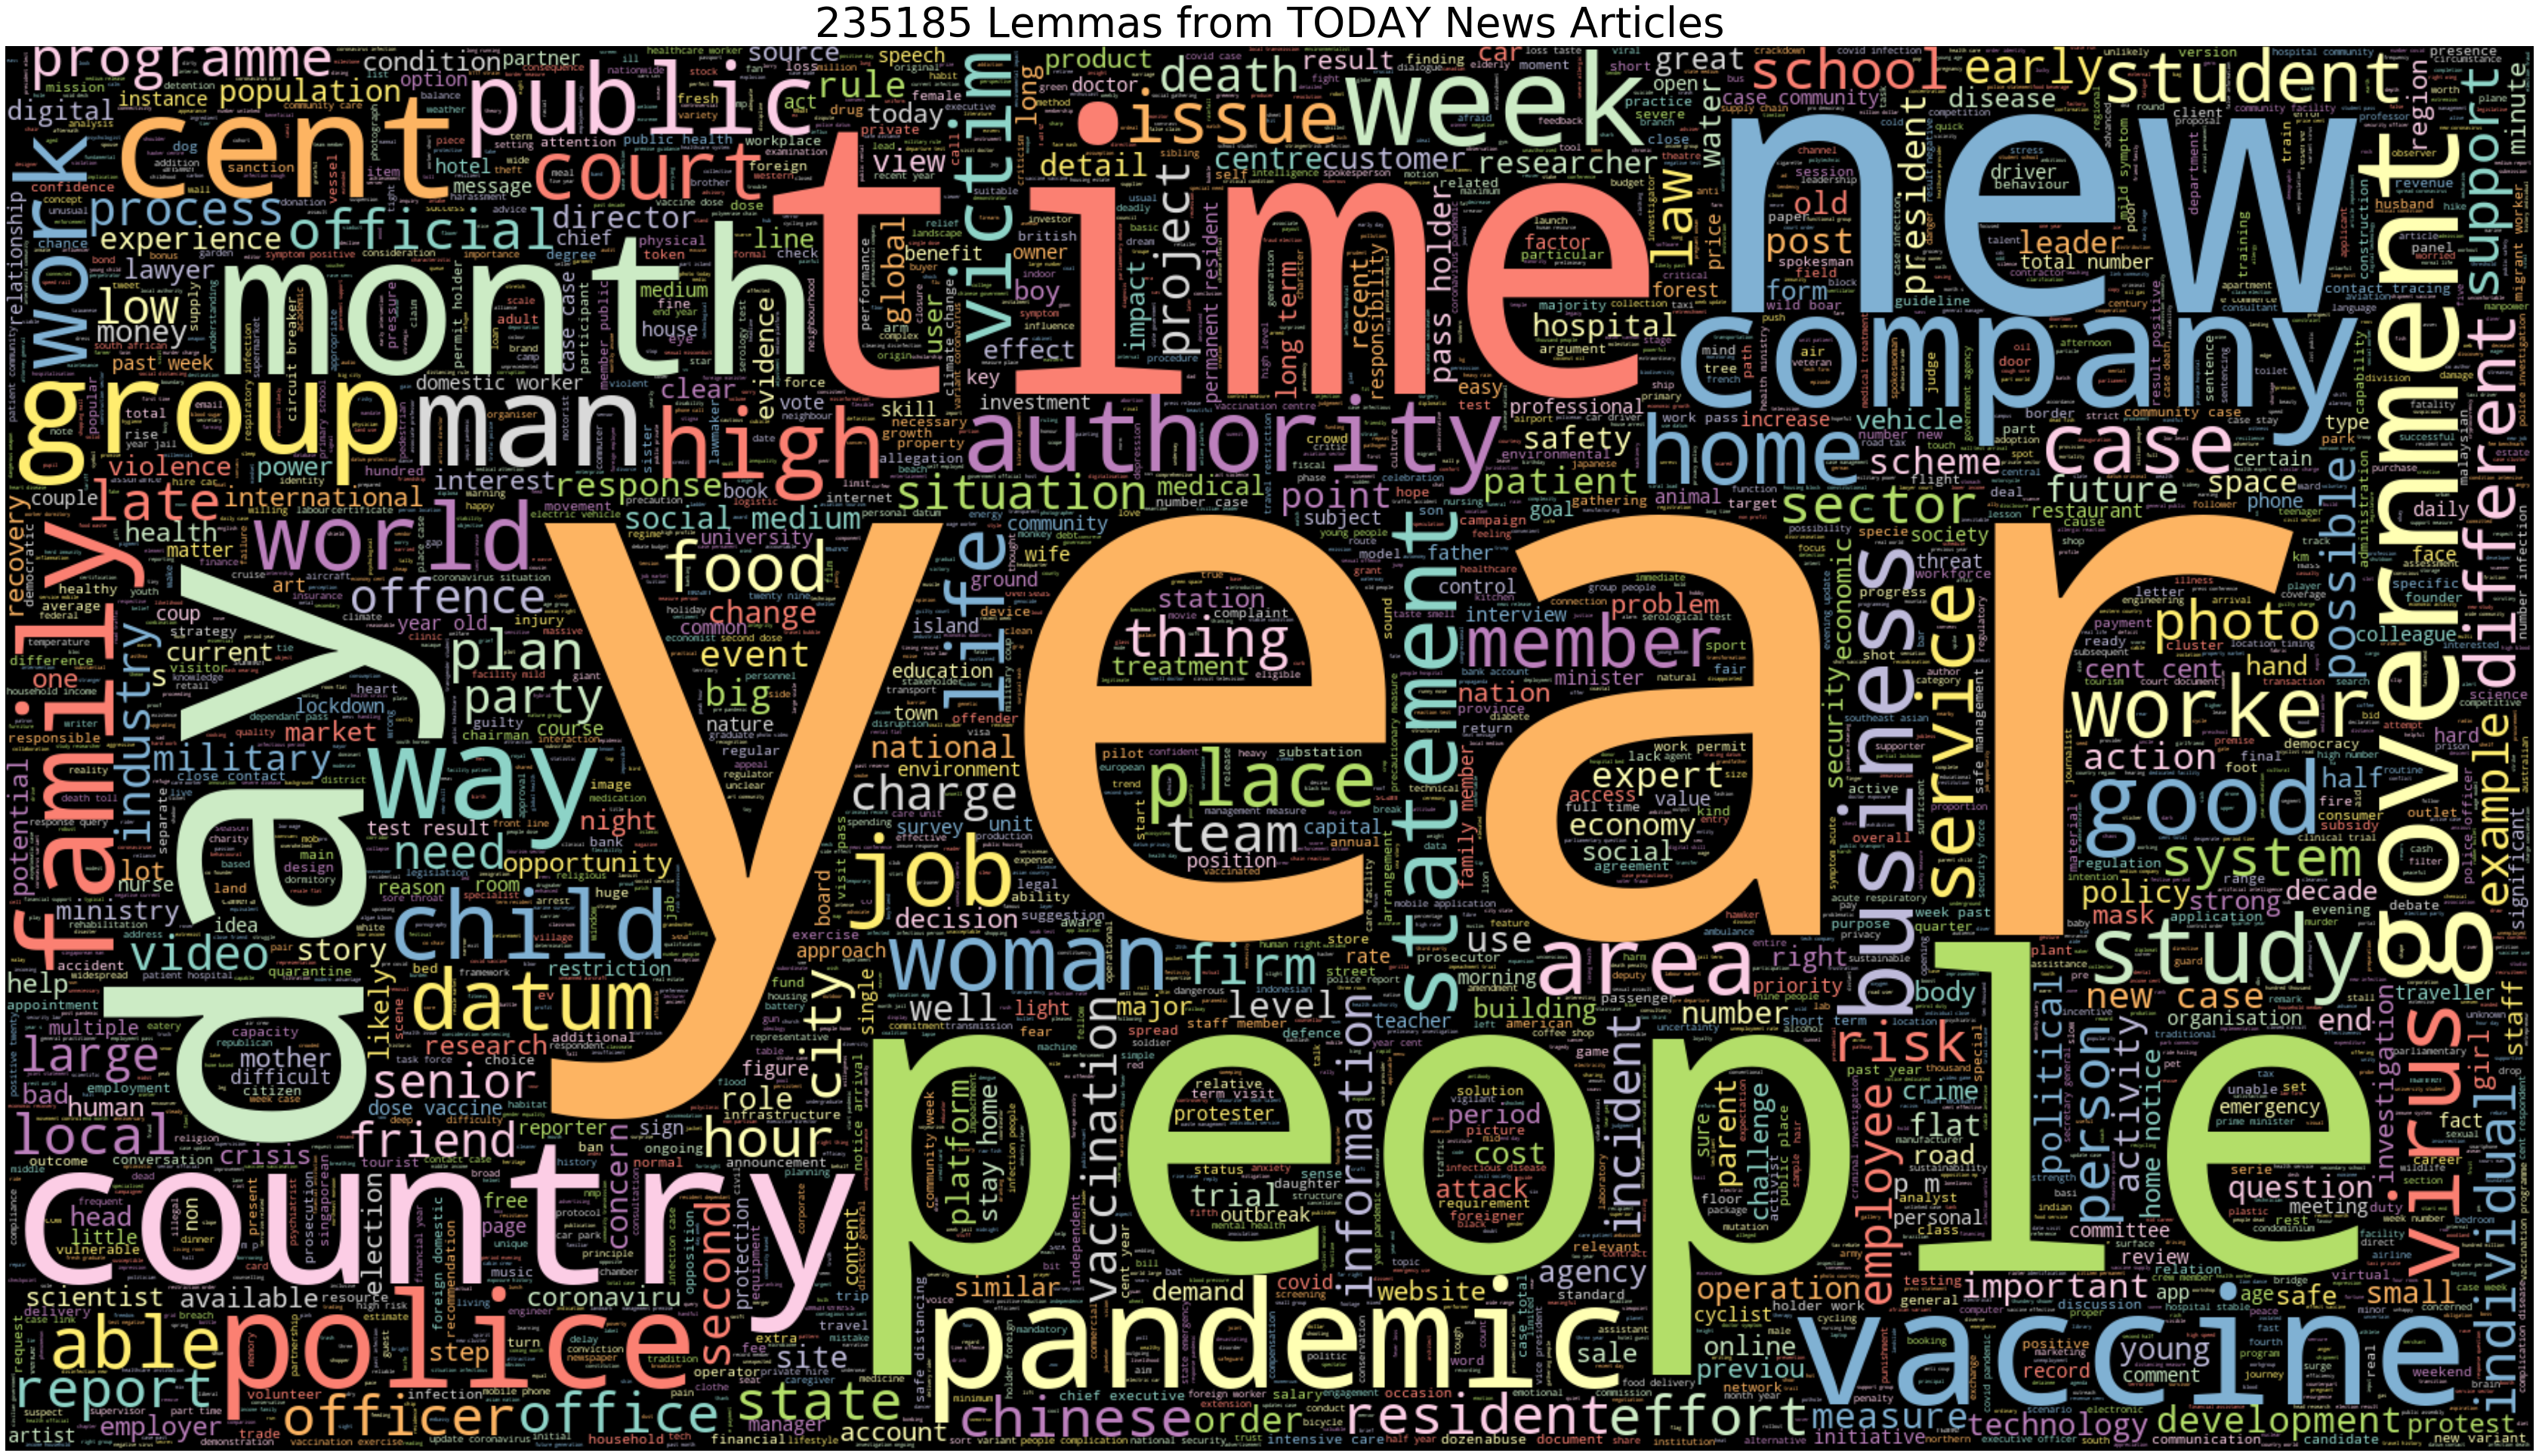

In [46]:
# Plot wordcloud
lemmas_wordcloud = plot_lemmas_wordcloud(lemmas_list)

In [31]:
# Extracting noun phrases

In [35]:
doc_list[0]

Singapore reported 10 new cases of Covid-19 on Saturday (Dec 26), all of which were imported. All 10 cases had been placed on stay-home notices or isolated upon arrival in Singapore, said the Ministry of Health (MOH) in a press release. The total number of Covid-19 cases in Singapore now stands at 58,519. "We are still working through the details of the cases, and further updates will be shared via the MOH press release that will be issued tonight," MOH said. This report will be updated. A new year is in sight but old practices must hold firm as far as Covid-19 is concerned.  So the days of safe distancing and wearing of masks when leaving home are going to be around for a long while yet, and such basic protective measures against the tricky coronavirus should be upheld as far as possible. Responding to TODAY's queries on how the pandemic might play out next year, Professor Leo Yee Sin, executive director of the National Centre for Infectious Diseases (NCID), said she foresees that "li